In [1]:
import os, gc
import pygrib
import numpy as np
import pandas as pd
import xarray as xr
import multiprocessing as mp
import matplotlib.pyplot as plt 


from glob import glob
from functools import partial
from matplotlib import gridspec
from datetime import datetime, timedelta

os.environ['OMP_NUM_THREADS'] = '1'

nbm_dir = '/scratch/general/lustre/u1070830/nbm/'
urma_dir = '/scratch/general/lustre/u1070830/urma/'
tmp_dir = '/scratch/general/lustre/u1070830/tmp/'
os.makedirs(tmp_dir, exist_ok=True)

In [2]:
def open_urma(f, cfengine='pynio'):
    try:
        ds = xr.open_dataset(f, engine=cfengine)
        ds['valid'] = datetime.strptime(f.split('/')[-1].split('.')[1], '%Y%m%d%H')
    except:
        return None
    else:
        return ds
    
def calc_pbin(pbin, _bint, _thresh, _data, _urma):

    p0, p1 = pbin-_bint/2, pbin+_bint/2

    n = xr.where((_data >= p0) & (_data < p1) & (_urma > _thresh), 1, 0)
    N = xr.where((_data >= p0) & (_data < p1), 1, 0)
    #rel = (n.sum(dim=['valid'])/N.sum(dim=['valid']))*100
    rel = (n.sum()/N.sum())*100

    return [pbin/100, rel/100, n.sum(), N.sum()]

In [3]:
extract_dir = nbm_dir + 'extract/'
extract_flist = sorted(glob(extract_dir + '*'))
extract_flist

['/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr024.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr030.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr036.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr042.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr048.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr054.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr060.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr066.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr072.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr078.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr084.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr090.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr096.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr102.nc',
 '/scratch/general/lustre/u1070830

In [4]:
if not os.path.isfile('./urma_agg.nc'):
    
    urma_flist = sorted([f for f in glob(urma_dir + '*.WR.grib2') if 'idx' not in f])
    print(len(urma_flist), ' URMA files to read')
    
    print('Producing URMA aggregate')

    with mp.get_context('fork').Pool(64) as p:
        urma = p.map(open_urma, urma_flist, chunksize=1)
        p.close()
        p.join()

    urma = [f for f in urma if f is not None]
    urma = xr.concat(urma, dim='valid').rename({'APCP_P8_L1_GLC0_acc':'apcp6h', 
                                                'xgrid_0':'x', 'ygrid_0':'y',
                                                'gridlat_0':'lat', 'gridlon_0':'lon'})
    
    urma = urma['apcp6h']
    
    print('Saving URMA aggregate to file')
    urma.to_netcdf('./urma_agg.nc')

else:
    print('Getting URMA aggregate from file')
    urma = xr.open_dataset('./urma_agg.nc')
    
urma_whole = urma['apcp6h']
urma_whole

Getting URMA aggregate from file


<xarray.DataArray 'apcp6h' (valid: 1049, y: 1051, x: 1132)>
[1248028868 values with dtype=float32]
Coordinates:
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
  * valid    (valid) datetime64[ns] 2020-02-01 ... 2020-10-22
Dimensions without coordinates: y, x
Attributes:
    center:                                         US National Weather Servi...
    production_status:                              Operational products
    long_name:                                      Total precipitation
    units:                                          kg m-2
    grid_type:                                      Lambert Conformal can be ...
    parameter_discipline_and_category:              Meteorological products, ...
    parameter_template_discipline_category_number:  [8 0 1 8]
    level_type:                                     Ground or water surface
    level:                                          0.0
    type_of_statistical_processing:                 Accumulation
    statistical_process_duration:                   initial time to forecast ...
    forecast_time:                                  6
    forecast_time_units:                            hours
    initial_time:                                   01/31/2020 (18:00)
    coordinates:                                    gridlat_0 gridlon_0

/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr024.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr030.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr036.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr042.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr048.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr054.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr060.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr066.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr072.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr078.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr084.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr090.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr096.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr102.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr108.nc


<ipython-input-12-f6c505a3c776>:98: RuntimeWarning: invalid value encountered in true_divide
  obs_freq_all = obs_count_all/fcast_count_all
<ipython-input-12-f6c505a3c776>:104: RuntimeWarning: invalid value encountered in true_divide
  climo = xr.where(urma > thresh, 1, 0).sum().values/urma.size


ValueError: arange: cannot compute length

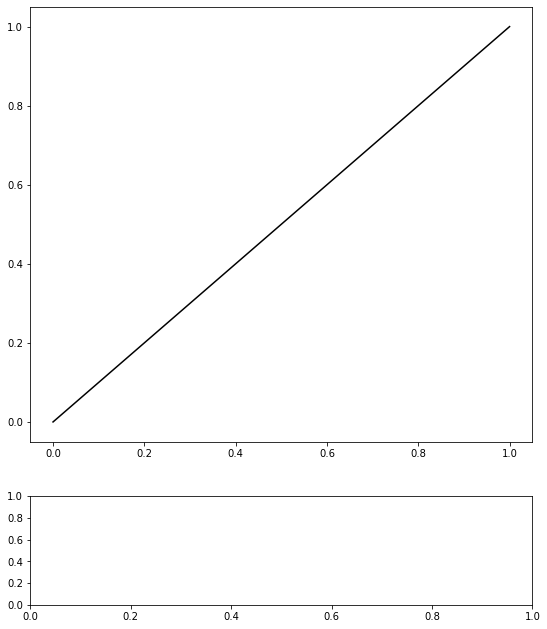

In [12]:
pbin_stats_all = {}

for thresh in [0.01, 0.25, 0.50]:
    for fhr in np.arange(24, 108+1, 6):
        
        open_file = [f for f in extract_flist if 'fhr%03d'%fhr in f][0]
        print(open_file)

        # Subset the times
        nbm = xr.open_dataset(open_file)
        nbm_time = nbm.valid
        urma_time = urma.valid

        time_match = nbm_time[np.in1d(nbm_time, urma_time)].values
        nbm = nbm.sel(valid=time_match)
        urma = urma_whole.sel(valid=time_match)

        date0 = pd.to_datetime(time_match[0]).strftime('%Y/%m/%d %H UTC')
        date1 = pd.to_datetime(time_match[-1]).strftime('%Y/%m/%d %H UTC')

        # Subset the grid
        # cwa = 'WESTUS'
        # nlat, xlat = 30, 50
        # nlon, xlon = -130, -110
        
        # cwa = 'SEW'
        # nlat, xlat = 46.0, 49.0
        # nlon, xlon = -125.0, -120.5
        
        # cwa = 'SLC'
        # nlat, xlat = 37.0, 42.0
        # nlon, xlon = -114.0, -110
        
        # cwa = 'MSO'
        # nlat, xlat = 44.25, 49.0
        # nlon, xlon = -116.75, -112.25
        
        # cwa = 'MTR'
        # nlat, xlat = 35.75, 38.75
        # nlon, xlon = -123.5, -120.25
        
        lats, lons = nbm.lat, nbm.lon

        idx = np.where(
            (lats >= nlat) & (lats <= xlat) &
            (lons >= nlon) & (lons <= xlon))

        nbm = nbm.isel(x=slice(idx[1].min(), idx[1].max()), y=slice(idx[0].min(), idx[0].max()))
        urma = urma.isel(x=slice(idx[1].min(), idx[1].max()), y=slice(idx[0].min(), idx[0].max()))

        # Subset the threshold value
        nbm = nbm.sel(threshold=thresh)['probx']

        total_fc = xr.where(nbm > 0, 1, 0).sum()
        total_ob = xr.where(urma > thresh, 1, 0).sum()

        bint = 5
        bins = np.arange(0, 101, bint)

        calc_pbin_mp = partial(calc_pbin, _bint=bint, _thresh=thresh,
                               _data=nbm, _urma=urma)
        
        with mp.get_context('fork').Pool(int(len(bins)/2)) as p:
            pbin_stats = p.map(calc_pbin_mp, bins, chunksize=1)
            p.close()
            p.join()

        pbin_stats_all[fhr] = np.array(pbin_stats)
        
    # Make the figure
    fig = plt.figure(figsize=(9, 11), facecolor='w') 
    axs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
    ax = plt.subplot(axs[0])
    ax1 = plt.subplot(axs[1])

    obs_count_all, fcast_count_all = [], []

    for fhr in pbin_stats_all.keys():
        pbin_stats = pbin_stats_all[fhr]

        # Calculate the reliability stats (and others?)
        fcast_prob = pbin_stats[:, 0]
        obs_freq = pbin_stats[:, 1]
        obs_count = pbin_stats[:, 2]
        fcast_count = pbin_stats[:, 3]

        obs_count_all.append(obs_count)
        fcast_count_all.append(fcast_count)

        ax.plot(fcast_prob, obs_freq, linewidth=1,
                marker='+', markersize=5, label='F%03d'%fhr)

    obs_count_all = np.array(obs_count_all).sum(axis=0)
    fcast_count_all = np.array(fcast_count_all).sum(axis=0)
    obs_freq_all = obs_count_all/fcast_count_all

    ax.plot(fcast_prob, obs_freq, linewidth=3, color='r',
            marker='+', markersize=15, label='ALL')

    perfect = np.arange(0, 1.1, .1)
    climo = xr.where(urma > thresh, 1, 0).sum().values/urma.size
    skill = perfect - ((perfect - climo)/2)

    ax.plot(perfect, perfect, 
            color='k')

    ax.axhline(climo, 
            color='k', linestyle='--')

    ax.plot(perfect, skill, 
            color='k', linestyle='--')

    fillperf = np.arange(climo, 1, .001)
    ax.fill_between(fillperf, fillperf - (fillperf - climo)/2, 1,
            color='gray', alpha=0.35)

    fillperf = np.arange(0, climo, .001)
    ax.fill_between(fillperf, 0, fillperf - (fillperf - climo)/2,
            color='gray', alpha=0.35)

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    ax.set_xticks(perfect)
    ax.set_yticks(perfect)

    ax.set_xlabel('Forecast Probability')
    ax.set_ylabel('Observed Relative Frequency')
    ax.grid(zorder=1)

    ax.set_title((
        'NBM Reliability Diagram\n' +
        '%s - %s\n'%(date0, date1) + 
        '%02dh Acc QPF | %3dh Lead Time\n\n'%(nbm.interval, nbm.fhr) +
        'Probability of Exceeding %.2f"\n\n'%thresh + 
        'n forecast prob > 0: %2.1e | n observed > %.2f: %2.1e'%(total_fc, thresh, total_ob)))

    ax.legend(loc='upper left')

    # # # # # # # # # # # # # # # # # # # # # # # #

    ax1.bar(bins, fcast_count_all, color='k', width=4.5, zorder=10)

    ax1.set_xticks(bins[::2])
    ax1.set_xticklabels(bins[::2]/100)
    ax1.set_xlim([0, 100])

    ax1.set_yscale('log')
    ax1.set_yticks([1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])

    ax1.set_xlabel('Forecast Probability')
    ax1.set_ylabel('# Forecasts')
    ax1.grid(zorder=-1)

    plt.show()